## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib as plt
import plotly.express as px
import seaborn as sns
from sklearn import datasets


In [5]:
# Load data
df = pd.read_csv("data.csv")
# Print shape of data to confirm data is loaded
df.head(n=5)


,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


# Data visualizations / Exploration

In [6]:
df.isna().sum()
# No missing values


type_school              0
school_accreditation     0
gender                   0
interest                 0
residence                0
parent_age               0
parent_salary            0
house_area               0
average_grades           0
parent_was_in_college    0
in_college               0
dtype: int64

In [7]:

cor = df.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(cor, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cor[mask] = np.nan
(cor
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))


C:\Users\aledo\AppData\Local\Temp\ipykernel_25312\3815975901.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (cor


,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
parent_age,nan,nan,nan,nan,nan,nan
parent_salary,-0.29,nan,nan,nan,nan,nan
house_area,0.11,0.14,nan,nan,nan,nan
average_grades,-0.01,0.31,0.41,nan,nan,nan
parent_was_in_college,-0.44,0.11,0.15,0.24,nan,nan
in_college,0.04,0.48,0.47,0.51,0.05,nan


Text(0.5, 1.0, 'Residence of Students')

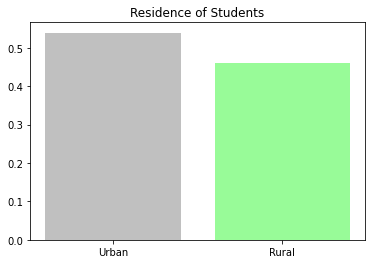

In [8]:

SIZE = 1000
y = df.value_counts("residence")/SIZE
plt.pyplot.bar(x=list(y.index), height=y, color=["silver", "palegreen"])
plt.pyplot.title('Residence of Students')


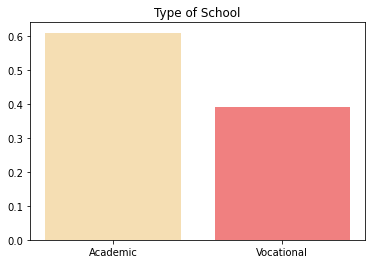

In [9]:
y = df.value_counts("type_school")/SIZE
plt.pyplot.bar(x=list(y.index), height=y, color=["wheat", "lightcoral"])
plt.pyplot.title("Type of School")
plt.pyplot.show()


parent_was_in_college
True     0.52
False    0.48
dtype: float64

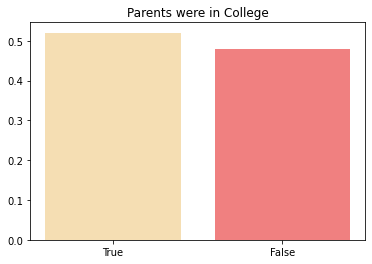

In [10]:
y = df.value_counts("parent_was_in_college")/SIZE
plt.pyplot.bar(x=["True", "False"], height=y, color=["wheat", "lightcoral"])
plt.pyplot.title("Parents were in College")
# plt.pyplot.show()
y


In [11]:
px.histogram(df, x="parent_age")


In [12]:
px.histogram(df, x="average_grades")


In [13]:
px.histogram(df, x="house_area")


In [14]:
px.histogram(df, x="parent_salary")


In [15]:
px.histogram(df, x="in_college")  # 50/50 split classes


# Cleaning and preprocessing

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import LeaveOneOut


In [92]:
# Test train splitting with random seed 18 and 20/80 split
X = df.drop('in_college', axis=1)
y = df['in_college']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
# Test set is 200 obs
# Train set is 800 obs



In [93]:
# Transformers, ENCODER
cat_trans = make_column_transformer(
    (OneHotEncoder(), [0, 1, 2, 3, 4, 9]), remainder='passthrough')

X = cat_trans.fit_transform(X)
X_train = cat_trans.fit_transform(X_train)
X_test = cat_trans.transform(X_test)

# Transformers, SCALER
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Using SVD the training set accuracy is: 85.625
Using SVD the test set accuracy is: 86.5


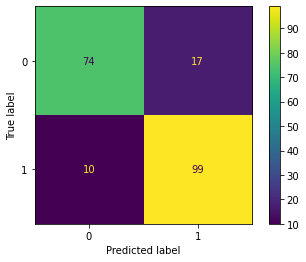

In [94]:

# One run of LDA
# Create model
svd_LDA = LinearDiscriminantAnalysis(solver="svd")

svd_LDA.fit_transform(X_train, y_train)
predicted = svd_LDA.predict(X_train)
actual = np.array(y_train)
print("Using SVD the training set accuracy is:", accuracy_score(predicted, actual)*100)

predicted = svd_LDA.predict(X_test)
actual = np.array(y_test)
print("Using SVD the test set accuracy is:", accuracy_score(predicted, actual)*100)

ConfusionMatrixDisplay(confusion_matrix(y_test, predicted, labels=svd_LDA.classes_ )).plot()

In [97]:
from sklearn.model_selection import cross_val_score
# Using ALL variables
loo = LeaveOneOut()
sum(cross_val_score(estimator=svd_LDA, X=X, y=y, cv=loo))/1000

0.862

In [193]:
# Dropping all categorical variables
cats = df.select_dtypes(include=['object']).columns.tolist()
cats.append('parent_was_in_college')
cats.append('in_college')

Xi = df.drop(cats, axis=1)

# Ordinal encoding
#lvls=['Not Interested','Less Interested', 'Uncertain', 'Quiet Interested', 'Very Interested']
#enc = OrdinalEncoder(categories=[lvls])
#enc.fit(df[['interest']])
#Xi['interest'] =  pd.DataFrame(enc.transform(df[['interest']]))[0]

# cat_trans = make_column_transformer((OneHotEncoder(), []), remainder='passthrough')
scaler = StandardScaler()

#Xi = cat_trans.fit_transform(Xi)
Xi = scaler.fit_transform(Xi)



81.3

In [195]:
lda = LinearDiscriminantAnalysis(solver="eigen",shrinkage="auto")
acc = 100*sum(cross_val_score(estimator=lda, X=Xi, y=y, cv=loo))/1000
print("The 4 variable model had an accuracy of ", acc, "percent using eigen solver and Leidot-wolf shrinkage." )

The 4 variable model had an accuracy of  81.3 percent.


Linear Discriminant Analysis makes the assumption that the variables are all jointly distributed with Gaussian (normal) distributions. Therefore, when we utilize categorical features to attempt classification, they are not handled well. Them being made up of 0s and 1s fails this condition and contributes little to the model.

Because of this, the all inclusive 10 variable model report a 86.2% accuracy using LOOCV, whereas the solely numeric model, reports 81.1% accuracy with just 4 features. This tells us that the categorical variables as a whole only contributed 5.1% of the accuracy, and are not worth having unless prediction is of the utmost concern. 

More discussion here:
https://stats.stackexchange.com/questions/158772/can-we-use-categorical-independent-variable-in-discriminant-analysis

Using QDA the training set accuracy is: 55.25
Using QDA the test set accuracy is: 59.0


c:\Users\aledo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning:

Variables are collinear



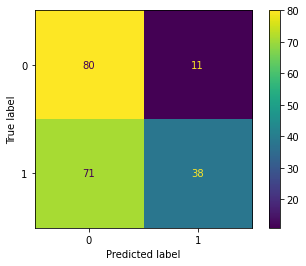

In [178]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# One run of LDA
# Create model
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train)
predicted = qda.predict(X_train)
actual = np.array(y_train)
print("Using QDA the training set accuracy is:", accuracy_score(predicted, actual)*100)

predicted = qda.predict(X_test)
actual = np.array(y_test)
print("Using QDA the test set accuracy is:", accuracy_score(predicted, actual)*100)

ConfusionMatrixDisplay(confusion_matrix(y_test, predicted, labels=qda.classes_ )).plot()

In [185]:

accAll=100*sum(cross_val_score(estimator=QuadraticDiscriminantAnalysis(), X=X, y=y, cv=loo))/1000
#print("Using all variables the accuracy is: ", acc, "percent.")

c:\Users\aledo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning:

Variables are collinear

c:\Users\aledo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning:

Variables are collinear

c:\Users\aledo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning:

Variables are collinear

c:\Users\aledo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning:

Variables are collinear

c:\Users\aledo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning:

Variables are collinear

c:\Users\aledo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning:

Variables are collinear

c:\Users\aledo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning:

Variables are collinear

c:\Users\aledo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning:

Variables are collinear

c:\Users\aledo\anaconda3\lib\site-packag

In [184]:

Xi = df.drop(cats, axis=1)

scaler = StandardScaler()

Xi = scaler.fit_transform(Xi)
accNumeric = 100*sum(cross_val_score(estimator=QuadraticDiscriminantAnalysis(), X=Xi, y=y, cv=loo))/1000


82.6